<a href="https://colab.research.google.com/github/Fazil004/Counterfactual-explanations-for-VIT-in-image-classification-tasks/blob/main/latest_trained_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALL AND IMPORT REQUIRED LIBRARIES

In [ ]:
# Step 1: Install required libraries
!pip install torch torchvision matplotlib

# Step 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

#LOAD AND PREPROCESS CIFAR-10 DATASET

In [ ]:
# Step 3: Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#BUILDING VISION TRANSFORMER FROM SCRATCH

In [ ]:
# Step 4: Build Vision Transformer (ViT) from scratch
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x, attn

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))
        self.transformer_blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        for block in self.transformer_blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        return self.head(cls_token_final)

#TRAINING THE MODEL
#20 EPOCH
#L4 GPU
#DURATION-5 HOURS AND 30 MINUTES

In [ ]:
# Step 5: Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):  # Train for 10 epochs
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 2.056899309158325
Epoch 2, Loss: 1.2709014415740967
Epoch 3, Loss: 0.826650083065033
Epoch 4, Loss: 1.0566527843475342
Epoch 5, Loss: 0.6243764758110046
Epoch 6, Loss: 0.8369028568267822
Epoch 7, Loss: 0.8585308194160461
Epoch 8, Loss: 0.9118014574050903
Epoch 9, Loss: 0.890657901763916
Epoch 10, Loss: 1.1601992845535278
Epoch 11, Loss: 0.8219695091247559
Epoch 12, Loss: 0.41775158047676086
Epoch 13, Loss: 0.32965806126594543
Epoch 14, Loss: 0.545996367931366
Epoch 15, Loss: 0.6452172994613647
Epoch 16, Loss: 0.5405147671699524
Epoch 17, Loss: 0.52774578332901
Epoch 18, Loss: 0.34100204706192017
Epoch 19, Loss: 0.3468829095363617
Epoch 20, Loss: 0.5694158673286438


#SAVE THE TRAINED MODEL
FOR FURTHER USE

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/VIT SAVED MODEL")

In [ ]:
# Step 6: Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 68.8%


In [ ]:
# Step 7: Load the saved model (optional, for verification)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/VIT SAVED MODEL"))

<ipython-input-11-59a9a177a33b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/VIT SAVED MODEL"))


<All keys matched successfully>

#VERIFYING PREDICTIONS

Original Image True Label: 3
Original Image Predicted Label: 3


Counterfactual Image Predicted Label: 5
Counterfactual successfully changed the prediction to the target class!


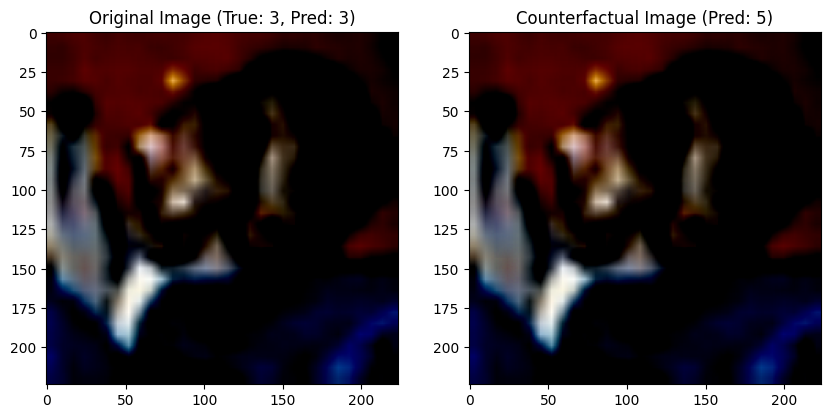

In [ ]:
# Step 8: Verify predictions for original and counterfactual images
def predict_image(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()

# Generate counterfactual image
def generate_counterfactual(model, image, target_class, steps=100, lr=0.01):
    image = image.unsqueeze(0).to(device).requires_grad_(True)
    for _ in range(steps):
        output = model(image)
        loss = criterion(output, torch.tensor([target_class]).to(device))
        loss.backward()
        image.data = image.data - lr * image.grad.data
        image.grad.zero_()
    return image.squeeze().detach().cpu()

# Example: Check predictions for an original and counterfactual image
image, true_label = test_dataset[0]
print(f"Original Image True Label: {true_label}")

# Predict original image
predicted_label = predict_image(model, image)
print(f"Original Image Predicted Label: {predicted_label}")

# Generate counterfactual image
target_class = 5  # Desired class
counterfactual = generate_counterfactual(model, image, target_class)

# Predict counterfactual image
counterfactual_predicted_label = predict_image(model, counterfactual)
print(f"Counterfactual Image Predicted Label: {counterfactual_predicted_label}")

# Verify if counterfactual is classified as the target class
if counterfactual_predicted_label == target_class:
    print("Counterfactual successfully changed the prediction to the target class!")
else:
    print("Counterfactual failed to change the prediction.")

# Visualize original and counterfactual images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Original Image (True: {true_label}, Pred: {predicted_label})")
plt.imshow(image.permute(1, 2, 0).numpy())

plt.subplot(1, 2, 2)
plt.title(f"Counterfactual Image (Pred: {counterfactual_predicted_label})")
plt.imshow(counterfactual.permute(1, 2, 0).numpy())
plt.show()